In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Initial imports
import numpy as np
import pickle
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor
from epimodel.pymc3_models.cm_effect.models import add_cms_to_plot

%matplotlib inline

setting environment variables properly now done.


In [49]:
cm_plot_style = [
#             ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf0c0", "darkgrey"), # ppl
            ("\uf0c0", "dimgrey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]


def mask_region(d, region, days=14):
    i = d.Rs.index(region)
    c_s = np.nonzero(np.cumsum(d.NewCases.data[i, :] > 0) == days + 1)[0][0]
    d_s = np.nonzero(np.cumsum(d.NewDeaths.data[i, :] > 0) == days + 1)[0]
    if len(d_s) > 0:
        d_s = d_s[0]
    else:
        d_s = len(d.Ds)

    d.Active.mask[i, c_s:] = True
    d.Confirmed.mask[i, c_s:] = True
    d.Deaths.mask[i, d_s:] = True
    d.NewDeaths.mask[i, d_s:] = True
    d.NewCases.mask[i, c_s:] = True

    return c_s, d_s

In [4]:
dp = DataPreprocessor(drop_HS=True)

In [5]:
def month_to_str(x):
    if x == 1:
        return "JAN"
    if x == 2:
        return "FEB"
    if x == 3:
        return "MAR"
    if x == 4:
        return "APR"
    if x == 5:
        return "MAY"

In [6]:
class ResultsObject():
    def __init__(self, indx, trace):
        self.CMReduction = trace.CMReduction
        self.RegionR = trace.RegionR[:, indx]
        self.InfectedCases = trace.InfectedCases[:, indx, :]
        self.InfectedDeaths = trace.InfectedDeaths[:, indx, :]
        self.ExpectedCases = trace.ExpectedCases[:, indx, :]
        self.ExpectedDeaths = trace.ExpectedDeaths[:, indx, :]
        
def produce_CIs(data):
    means = np.median(data, axis=0)
    li = np.percentile(data, 2.5, axis=0)
    ui = np.percentile(data, 97.5, axis=0)
    err = np.array([means - li, ui - means])
    return means, li, ui, err

In [10]:
data = dp.preprocess_data("double_entry_final.csv", last_day="2020-05-30", schools_unis="lol")
data.mask_reopenings()

start_d_i = 30 

for r_i, r in enumerate(data.Rs):
    p_i = r_i % 12
    
    f_i = int(r_i/12)
    
    if r_i == 0:
        plt.figure(figsize=(10, 14), dpi=300)
    elif r_i % 12 == 0:
        plt.tight_layout()
        ax.legend(shadow=True, fancybox=True, loc = "upper center", bbox_to_anchor = (-0.85, -0.25), fontsize=8, ncol=4)
        plt.savefig(f"FigureHoldouts{f_i}.pdf", bbox_inches='tight')
        plt.figure(figsize=(10, 13), dpi=300)
    elif r_i + 1 == len(data.Rs):
        plt.tight_layout()
        ax.legend(shadow=True, fancybox=True, loc = "upper center", bbox_to_anchor = (1.9, -0.25), fontsize=8, ncol=4)
        plt.savefig(f"FigureH oldouts{f_i+1}.pdf", bbox_inches='tight')
        
        
    
    plt.subplot(4, 3, p_i + 1)
    ax = plt.gca()
    
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]-3
    else:
        end_d_i = len(data.Ds)
    mask_region(data, r)
    
    res = pickle.load(open(f"../../server/ho_results_final4/{r}.pkl", "rb"))
    
    means_d, lu_id, up_id, err_d = produce_CIs(
                res.InfectedDeaths
            )
    
    means_c, lu_ic, up_ic, err_c = produce_CIs(
                res.InfectedCases
            )

    ec = res.ExpectedDeaths
    nS, nDs = ec.shape
    
    try:
        dist = pm.NegativeBinomial.dist(mu=ec, alpha=60)
        ec_output = dist.random()
    except ValueError:
        ec_output = 0 * ec
        means_d = means_d * 0
        lu_id = lu_id * 0
        up_id = up_id * 0

    means_expected_deaths, lu_ed, up_ed, err_expected_deaths = produce_CIs(
        ec_output
    )
    
    eco = res.ExpectedCases
    nS, nDs = eco.shape
    
    try:
        dist = pm.NegativeBinomial.dist(mu=eco, alpha=60)
        eco_output = dist.random()
    except ValueError:
        eco_output = 10**-10 * ec

    means_expected_cases, lu_ec, up_ec, err_expected_cases = produce_CIs(
        eco_output
    )
    

    days = data.Ds
    days_x = np.arange(len(days))
    deaths = data.NewDeaths[r_i, :]
    cases = data.NewCases[r_i, :]

    ax = plt.gca()
    plt.plot(
        days_x,
        means_d,
        label="Daily Infections - Later Fatal",
        zorder=1,
        color="tab:orange",
        alpha=0.25
    )

    plt.fill_between(
        days_x, lu_id, up_id, alpha=0.15, color="tab:orange", linewidth=0
    )

    plt.plot(
        days_x,
        means_expected_deaths,
        label="Predicted Daily Deaths",
        zorder=2,
        color="tab:red"
    )

    plt.fill_between(
        days_x, lu_ed, up_ed, alpha=0.25, color="tab:red", linewidth=0
    )

    plt.scatter(
        days_x,
        deaths,
        label="Recorded Daily Deaths (Smoothed)",
        marker="o",
        s=10,
        color="tab:red",
        alpha=0.9,
        zorder=3,
    )

    plt.scatter(
        days_x,
        deaths.data,
        label="Heldout Daily Deaths (Cases)",
        marker="o",
        s=12,
        edgecolor="tab:red",
        facecolor="white",
        linewidth=1,
        alpha=0.9,
        zorder=2,
    )
    
    plt.plot(
        days_x,
        means_c,
        label="Daily Infections - Later Reported",
        zorder=1,
        color="tab:purple",
        alpha=0.25
    )

    plt.fill_between(
        days_x, lu_ic, up_ic, alpha=0.15, color="tab:purple", linewidth=0
    )

    plt.plot(
        days_x,
        means_expected_cases,
        label="Predicted Daily Confirmed Cases",
        zorder=2,
        color="tab:blue"
    )

    plt.fill_between(
        days_x, lu_ec, up_ec, alpha=0.25, color="tab:blue", linewidth=0
    )

    plt.scatter(
        days_x,
        cases,
        label="Recorded Daily Confirmed Cases (Smoothed)",
        marker="o",
        s=10,
        color="tab:blue",
        alpha=0.9,
        zorder=3,
    )

    plt.scatter(
        days_x,
        cases.data,
        label="Heldout Daily Confirmed Cases (Cases)",
        marker="o",
        s=12,
        edgecolor="tab:blue",
        facecolor="white",
        linewidth=1,
        alpha=0.9,
        zorder=2,
    )

    ax.set_yscale("log")
    plt.ylim([10 ** 0, 10 ** 6])
    locs = np.arange(start_d_i, end_d_i, 14)
    xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30, ha="left")
    plt.xlim((start_d_i, end_d_i))
    
    add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)
    plt.title(data.RNames[r][0], fontsize=12)

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Masking GE from 2020-05-26 00:00:00+00:00
Masking GE from 2020-05-27 00:00:00+00:00
Masking DE from 2020-04-23 00:00:00+00:00
Masking DE from 2020-05-07 00:00:00+00:00
Masking DE from 2020-05-09 00:00:00+00:00
Masking GR from 2020-05-07 00:00:0

NameError: name 'f' is not defined

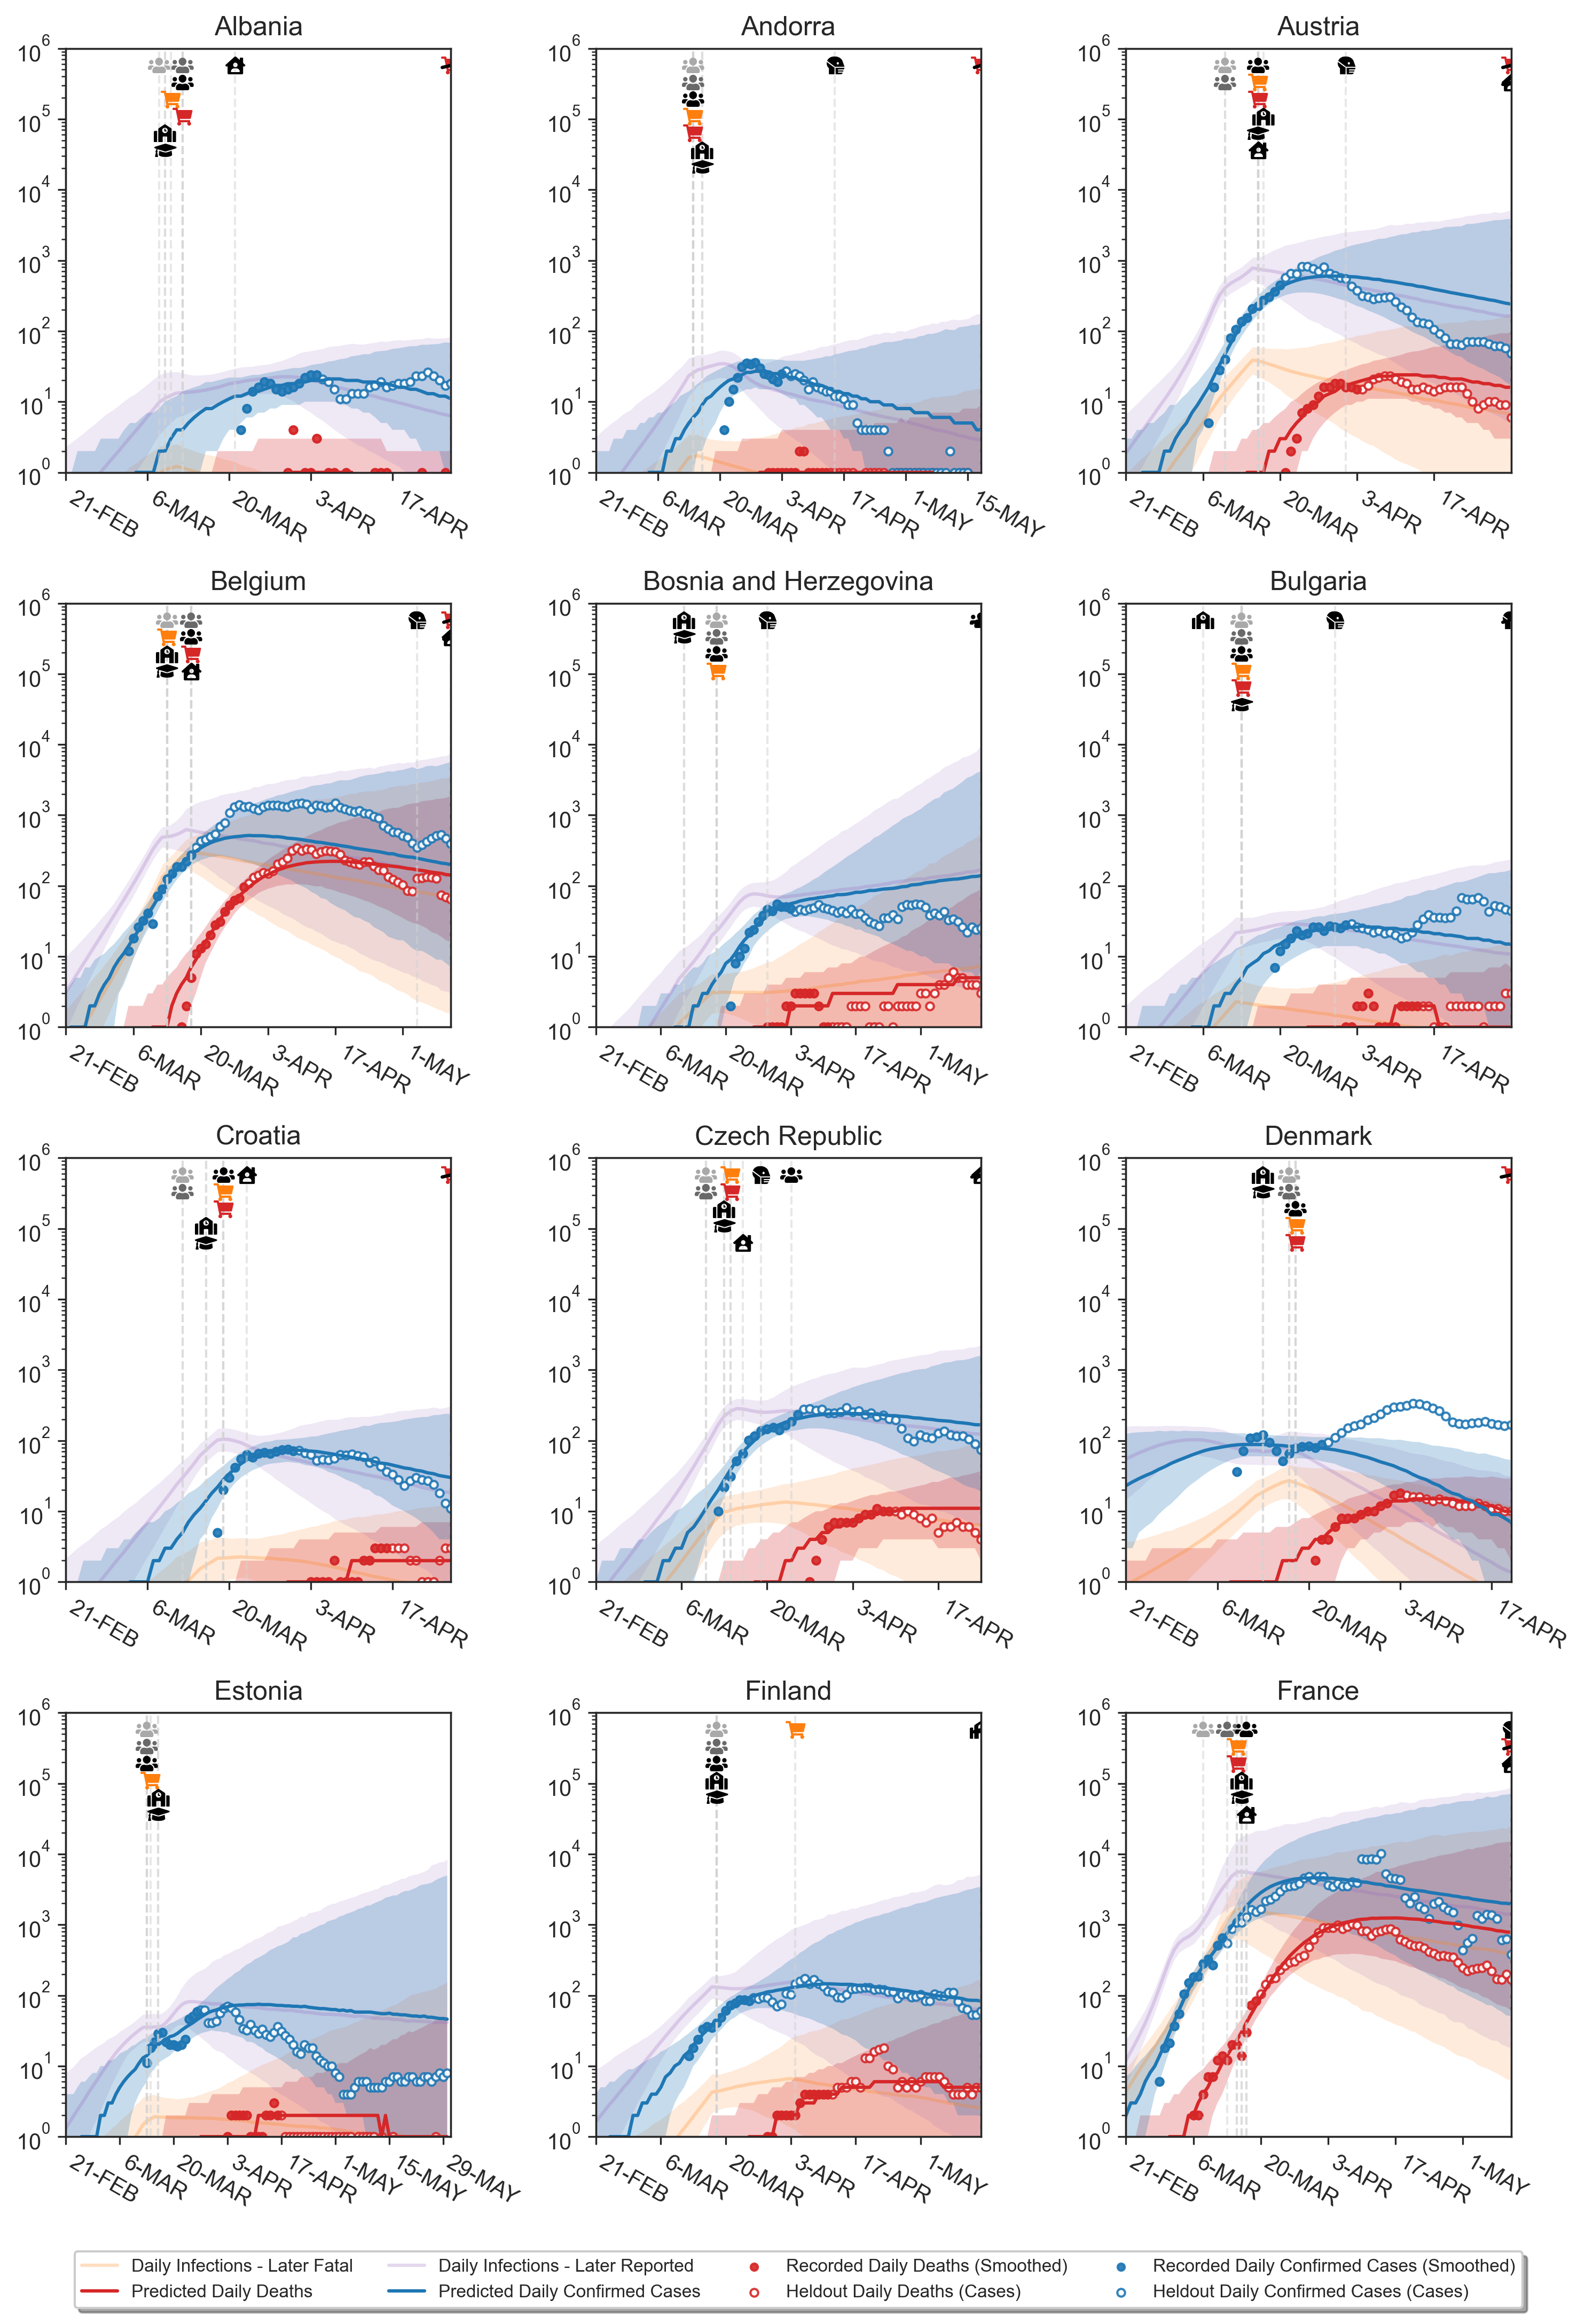

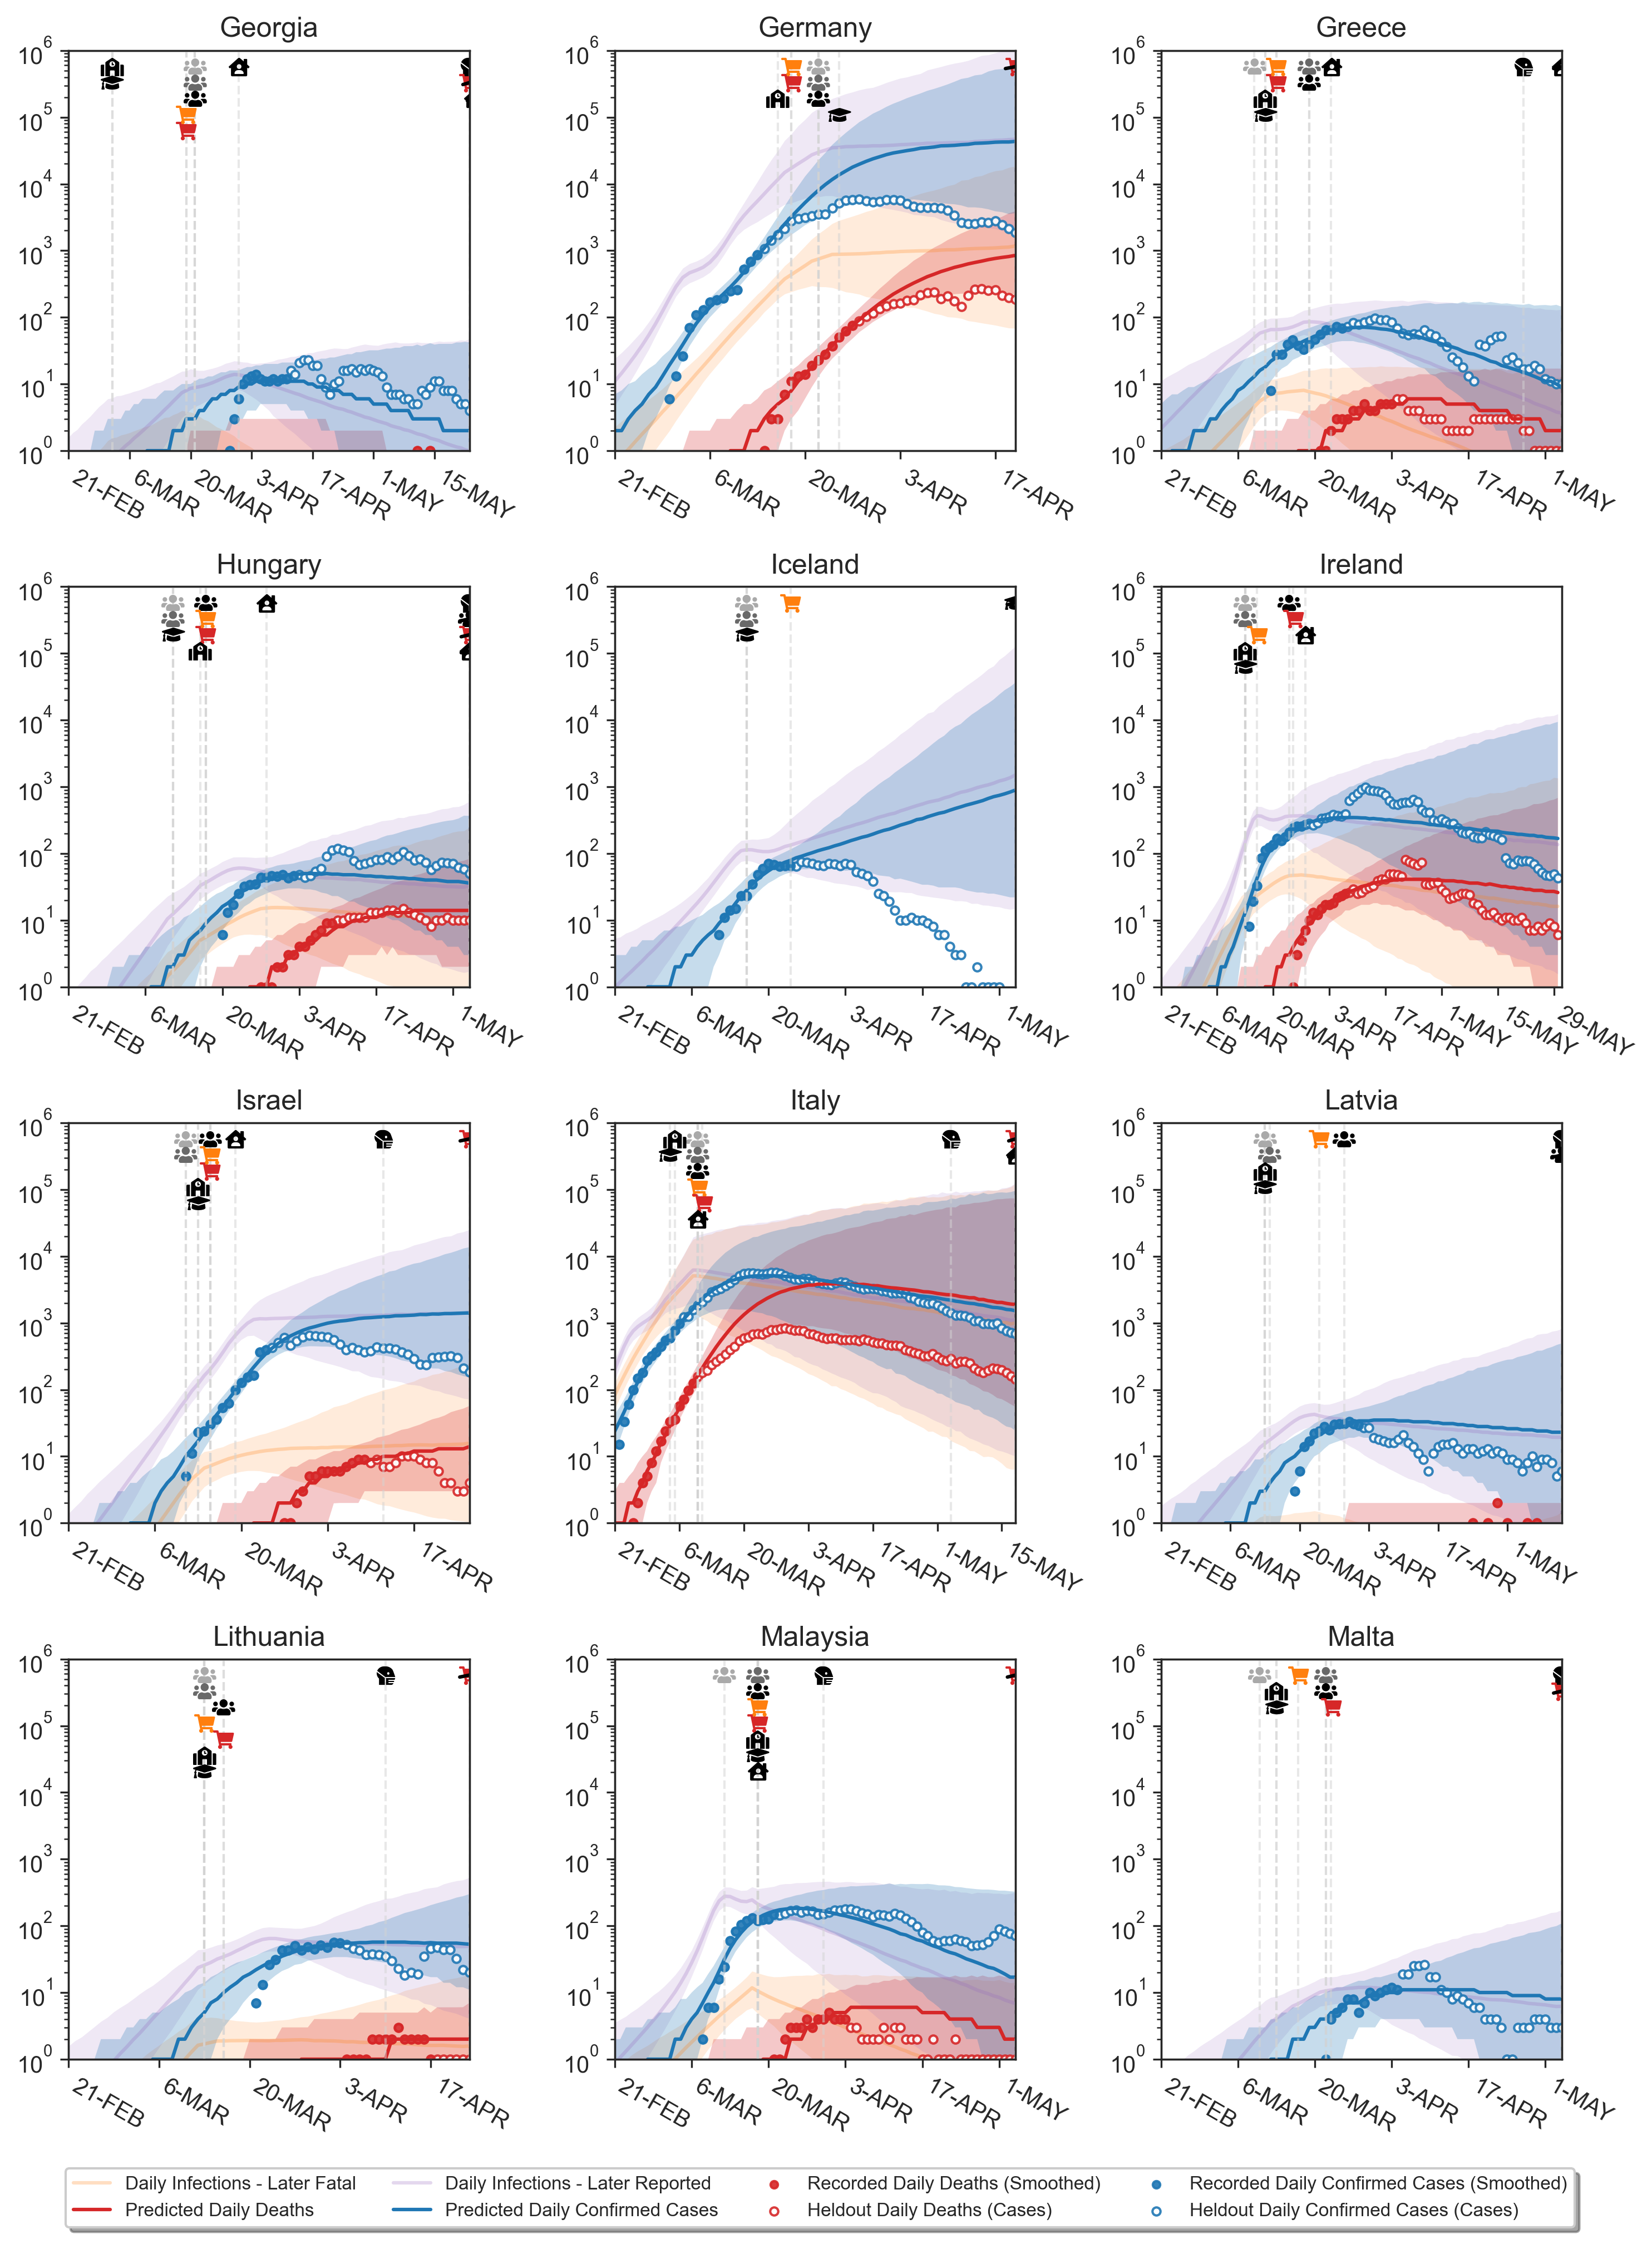

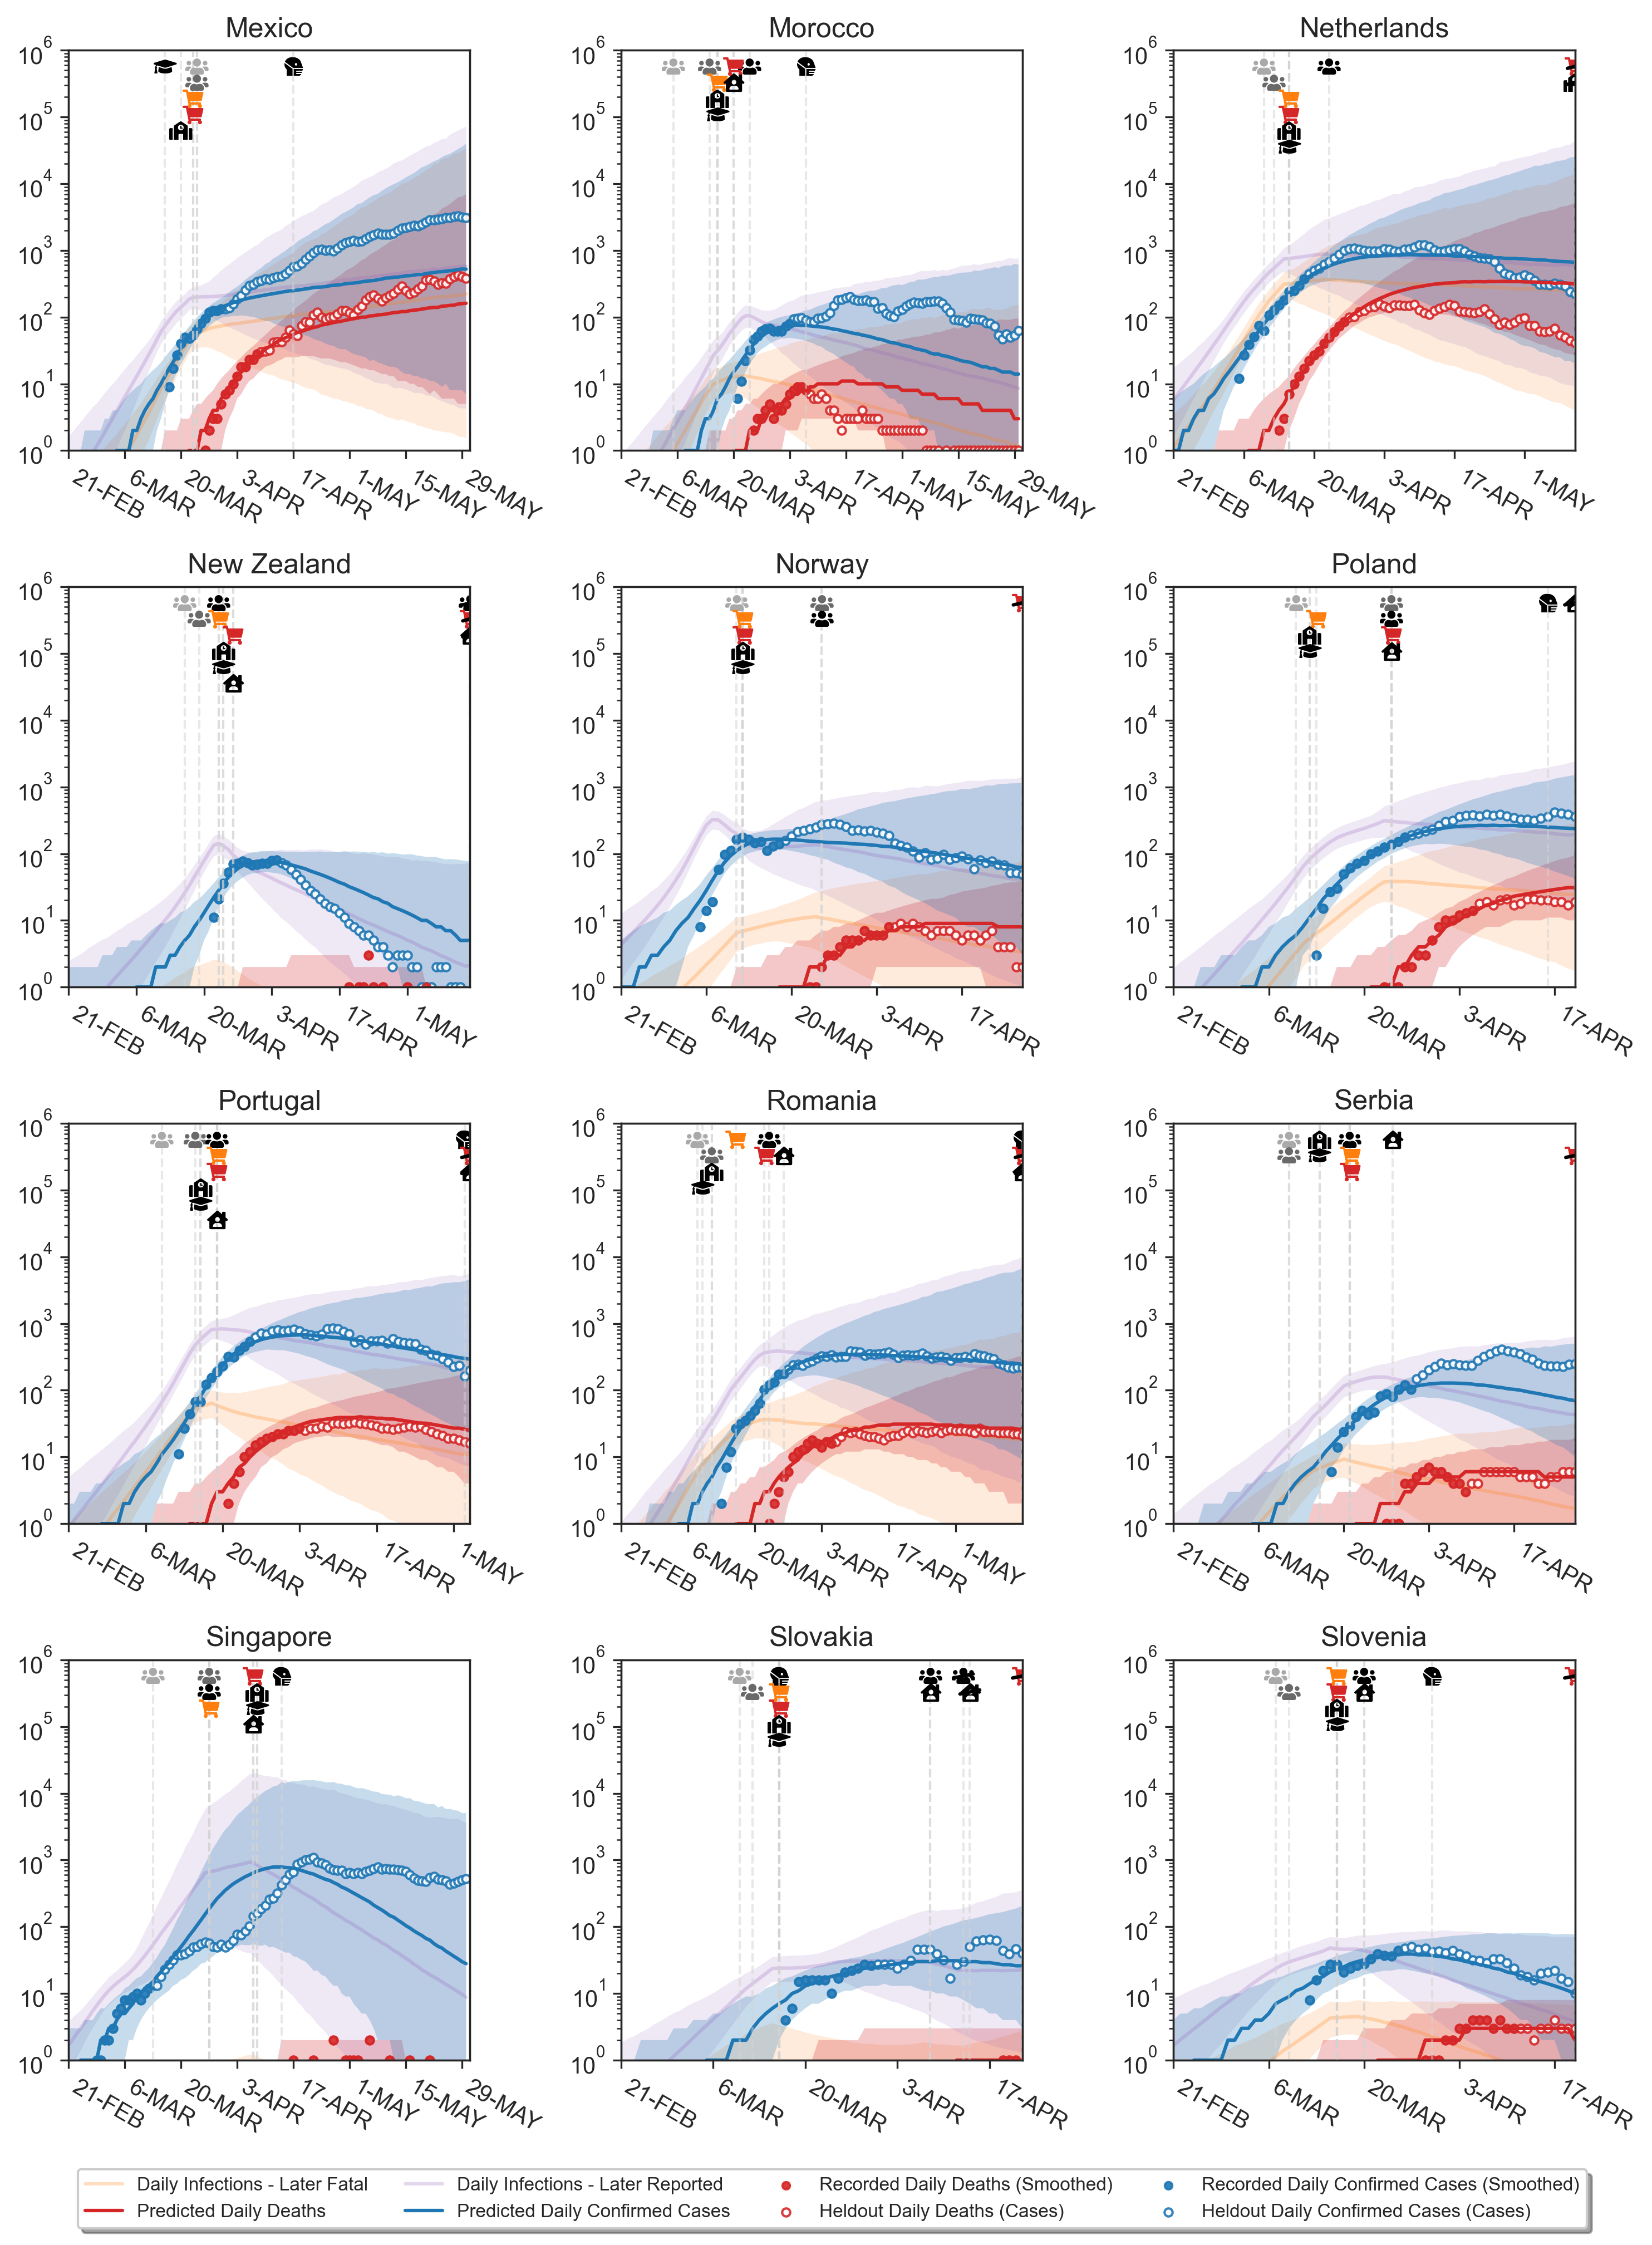

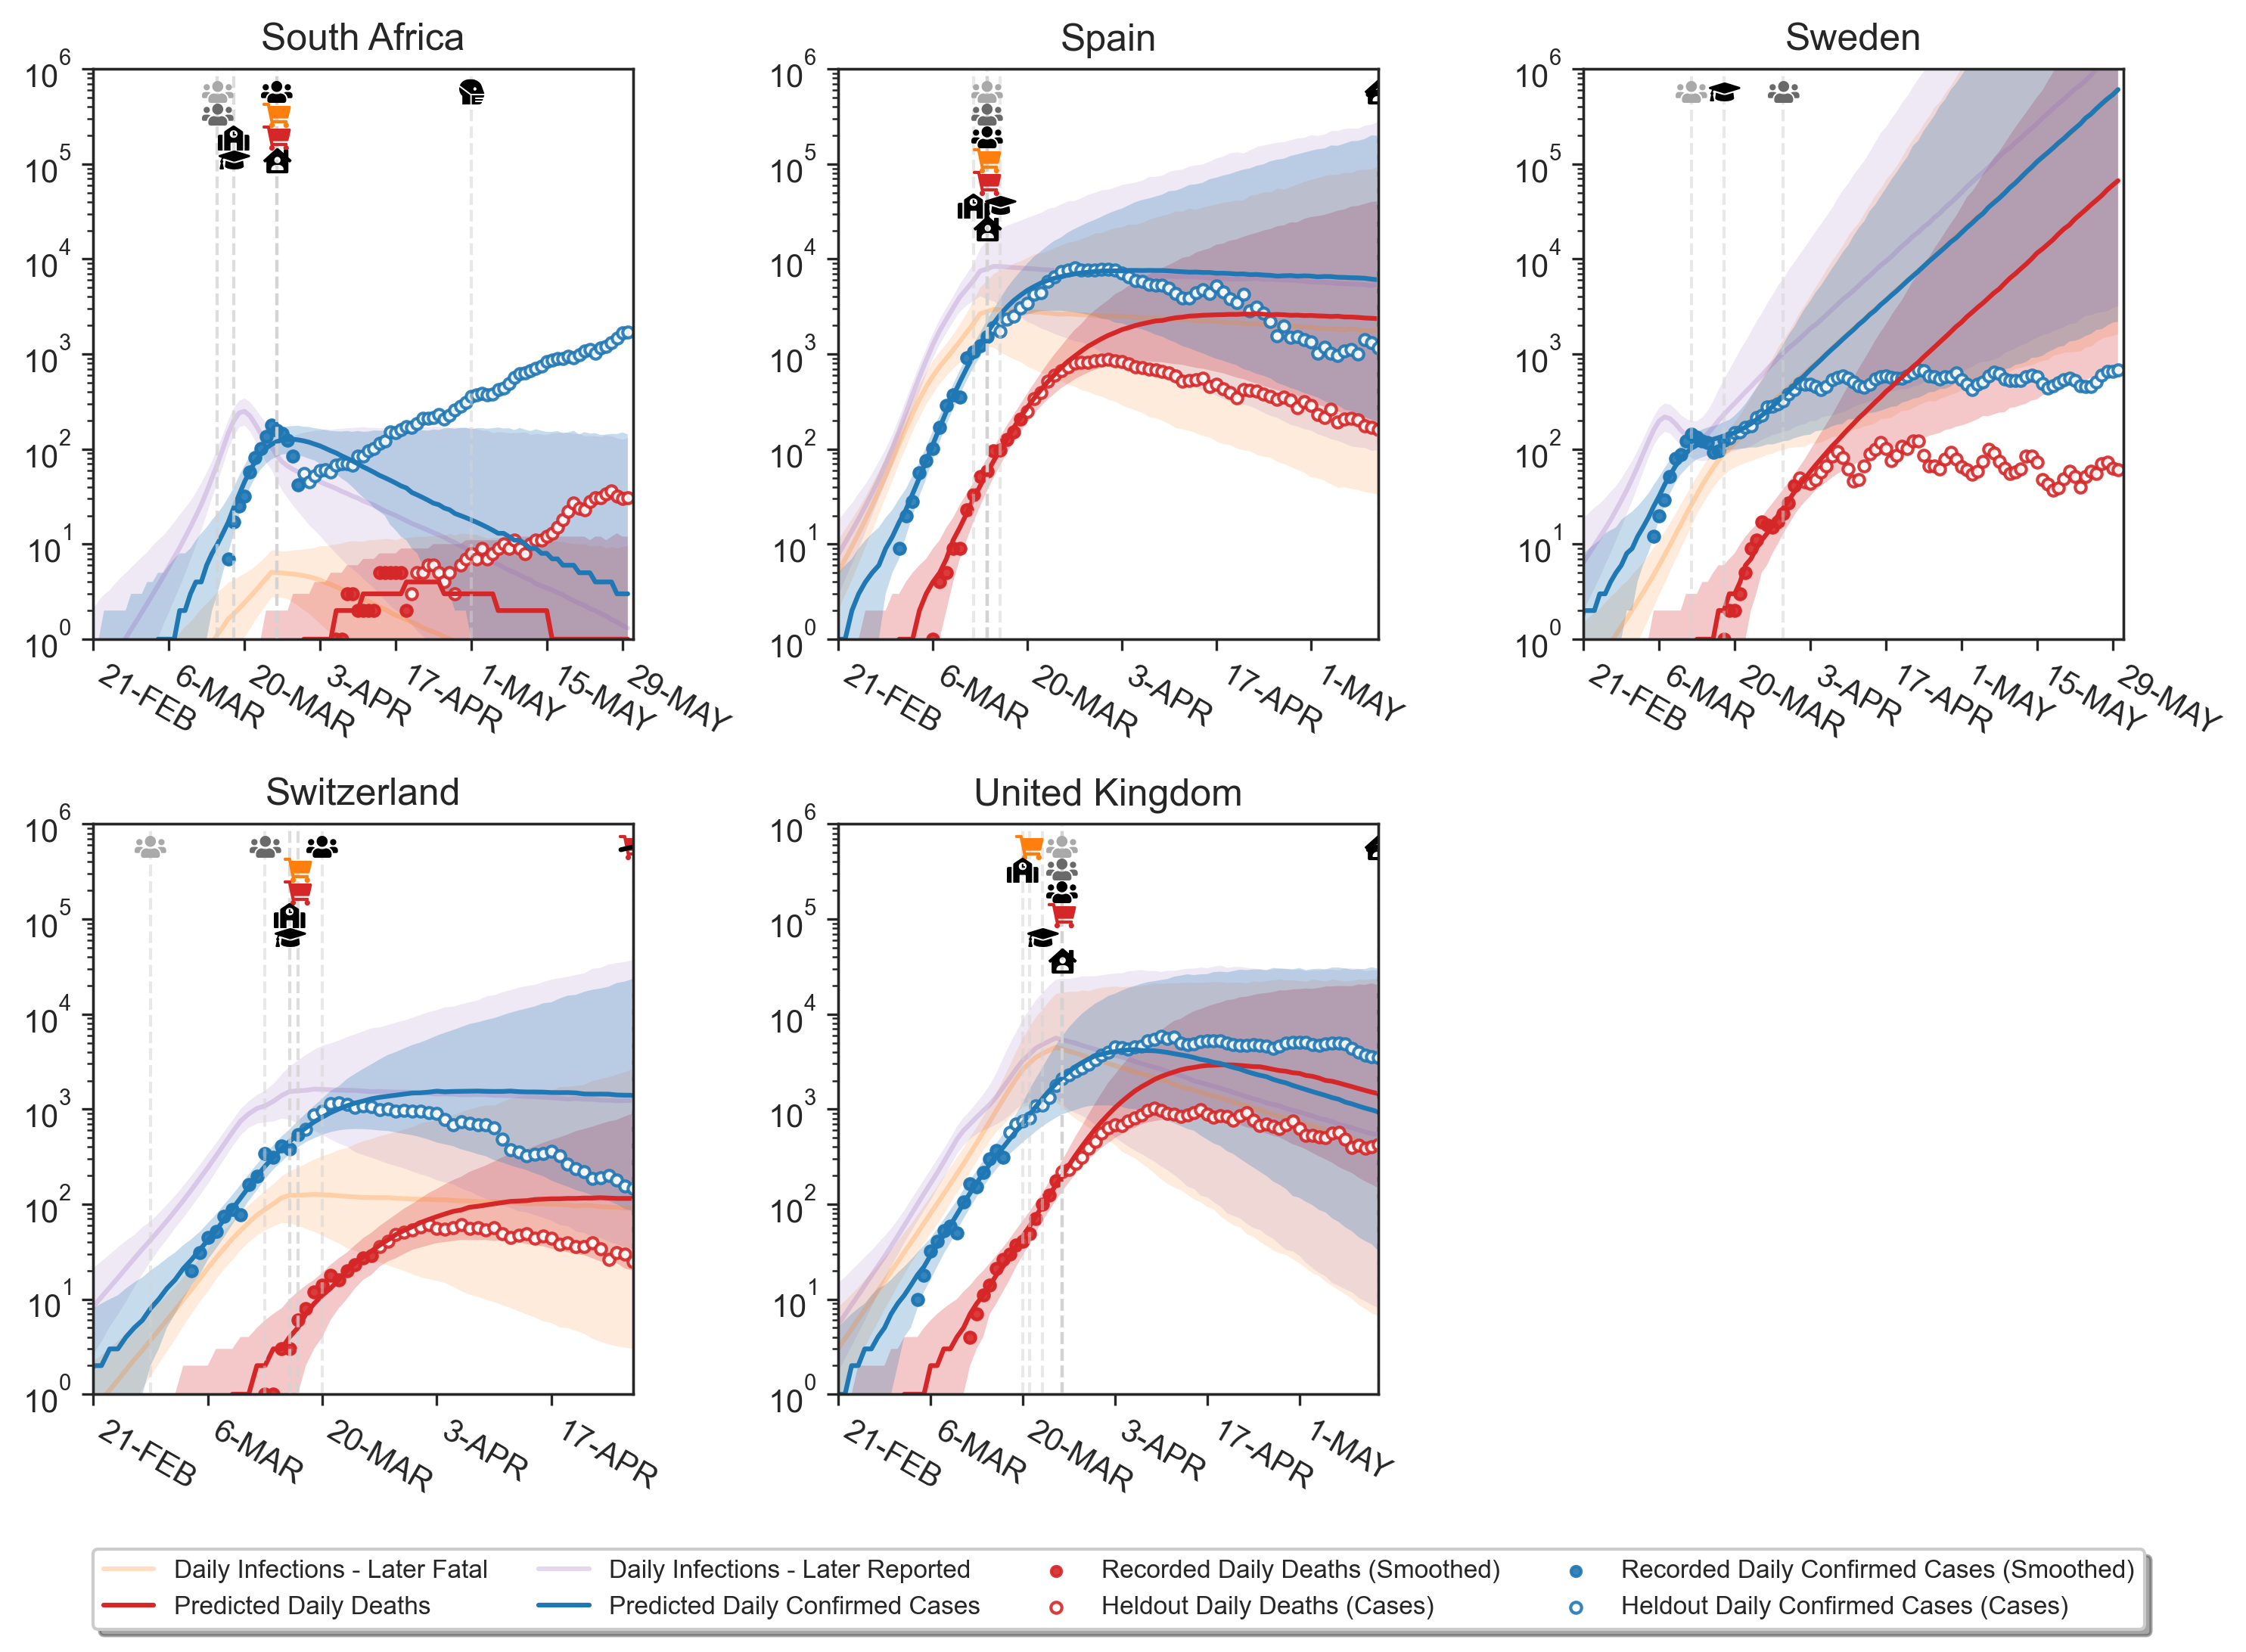

In [11]:
f

# PIT Histograms

In [26]:
from scipy.stats import nbinom

In [68]:
cdf_vals_cases = np.array([])
cdf_vals_deaths = np.array([])

for rg in data.Rs:
    res = pickle.load(open(f"../../server/ho_results_final4/{rg}.pkl", "rb"))
    nS, _ = res.ExpectedDeaths.shape

    r_i = data.Rs.index(rg)
    cases_start, deaths_start = mask_region(data, rg)
    total_cms = data.ActiveCMs[r_i, :, :]
    diff_cms = np.zeros_like(total_cms)
    diff_cms[:, 1:] = total_cms[:, 1:] - total_cms[:, :-1]
    ds = np.nonzero(np.any(diff_cms < 0, axis=0))
    if len(ds[0]) > 0:
        cases_end = ds[0][0]+3
        deaths_end = ds[0][0]+12
    else:
        cases_end = len(data.Ds)-1
        deaths_end = cases_end

    nd_cases_rg = cases_end - cases_start + 1
    nd_deaths_rg = deaths_end - deaths_start + 1

    # now actually compute likelihoods
    if nd_deaths_rg > 5:
        expected_deaths = res.ExpectedDeaths[:, deaths_start:(deaths_end+1)]
        mu = expected_deaths
        alpha = 60    
        p = alpha / (alpha + mu)
        cdf = nbinom.cdf(data.NewDeaths.data[r_i, deaths_start:(deaths_end+1)], alpha, p)
        cdf_vals_deaths = np.append(cdf_vals_deaths, np.mean(cdf, axis=0))

    expected_cases = res.ExpectedCases[:, cases_start:(cases_end+1)]
    mu = expected_cases
    alpha = 60    
    p = alpha / (alpha + mu)
    cdf = nbinom.cdf(data.NewCases.data[r_i, cases_start:(cases_end+1)], alpha, p)
    cdf_vals_cases = np.append(cdf_vals_cases, np.mean(cdf, axis=0))

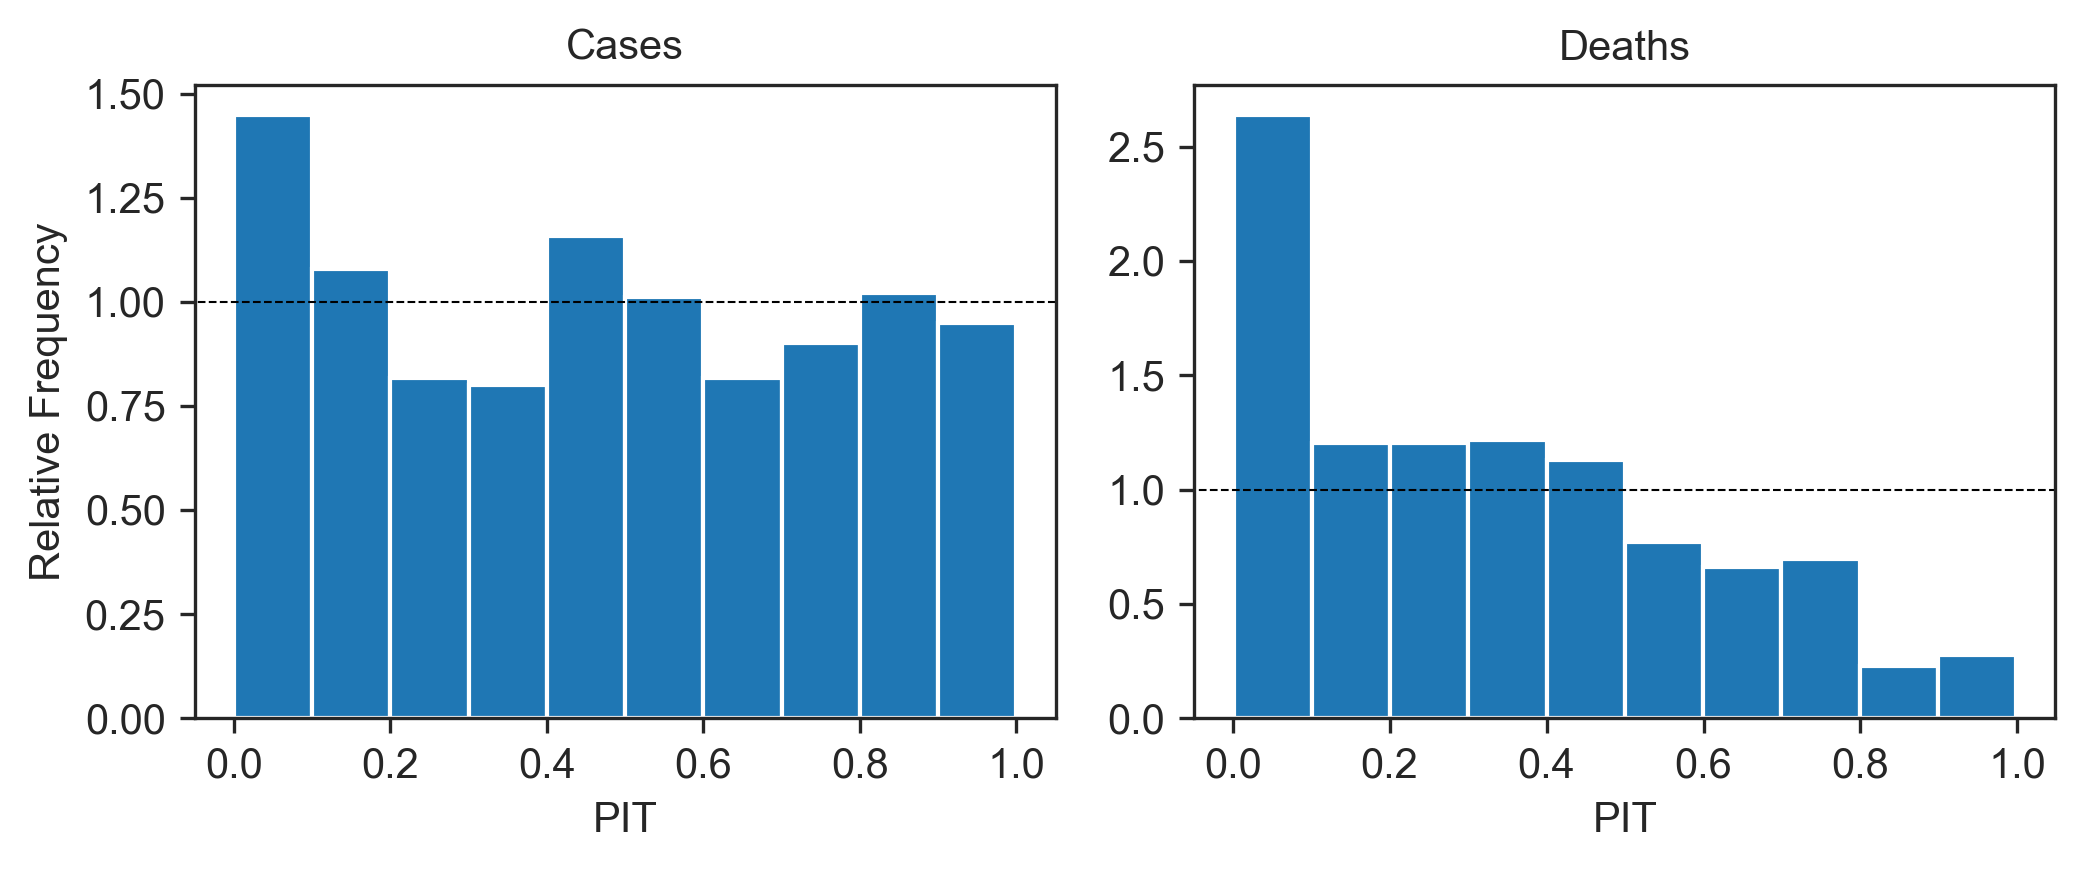

In [107]:
plt.figure(figsize=(7, 3), dpi=300)
plt.subplot(121)
plt.hist(cdf_vals_cases, bins=10, density=True)
plt.title('Cases', fontsize=10)
plt.xlabel('PIT', fontsize=10)
plt.ylabel('Relative Frequency')
plt.xlim(plt.xlim())
plt.plot([-1, 2], [1, 1], 'k--', linewidth=0.5)

plt.subplot(122)
plt.hist(cdf_vals_deaths, bins=10, density=True)
plt.title('Deaths', fontsize=10)
plt.xlabel('PIT', fontsize=10)
plt.xlim(plt.xlim())
plt.plot([-1, 2], [1, 1], 'k--', linewidth=0.5)

plt.tight_layout()
plt.savefig('PIT_sep.pdf', bbox_inches='tight')

In [112]:
exp_dir = "../../server/additional_exps"

def load_exp(exp_num, local=False):
    if not local:
        return pickle.load(open(f"{exp_dir}/exp_{exp_num}.pkl", "rb"))
    else:
        return pickle.load(open(f"../../additional_exps/exp_{exp_num}.pkl", "rb"))

In [113]:
res_ho = load_exp(17, True)

data = dp.preprocess_data("../../notebooks/double-entry-data/double_entry_final.csv", last_day="2020-05-30",
                                  schools_unis="whoops")
data.mask_region_ends()
# and mask earlier if needed
data.mask_reopenings(n_extra=20)

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Masking GE from 2020-05-26 00:00:00+00:00
Masking GE from 2020-05-27 00:00:00+00:00
Masking DE from 2020-04-23 00:00:00+00:00
Masking DE from 2020-05-07 00:00:00+00:00
Masking DE from 2020-05-09 00:00:00+00:00
Masking GR from 2020-05-07 00:00:0

In [114]:
cdf_vals_cases_agg = np.array([])
cdf_vals_deaths_agg = np.array([])

alpha = np.mean(res_ho.Phi_1)
nS = res_ho.Phi_1.shape 
for indx, region in enumerate(data.Rs):
    
    dd = np.nonzero(data.NewDeaths.mask[indx, :])[0][0]
    cd = np.nonzero(data.NewCases.mask[indx, :])[0][0]
    
    ed = res_ho.ExpectedDeaths[:, indx, dd:dd+19]
    ec = res_ho.ExpectedCases[:, indx, cd:cd+19]
    deaths = data.NewDeaths.data[indx, dd:dd+19]
    cases = data.NewCases.data[indx, cd:cd+19]

    expected_deaths = ed
    mu = expected_deaths
    alpha = 60    
    p = alpha / (alpha + mu)
    cdf = nbinom.cdf(deaths, alpha, p)
    cdf_vals_deaths_agg = np.append(cdf_vals_deaths_agg, np.mean(cdf, axis=0))

    expected_cases = ec
    mu = expected_cases
    alpha = 60    
    p = alpha / (alpha + mu)
    cdf = nbinom.cdf(cases, alpha, p)
    cdf_vals_cases_agg = np.append(cdf_vals_cases_agg, np.mean(cdf, axis=0))

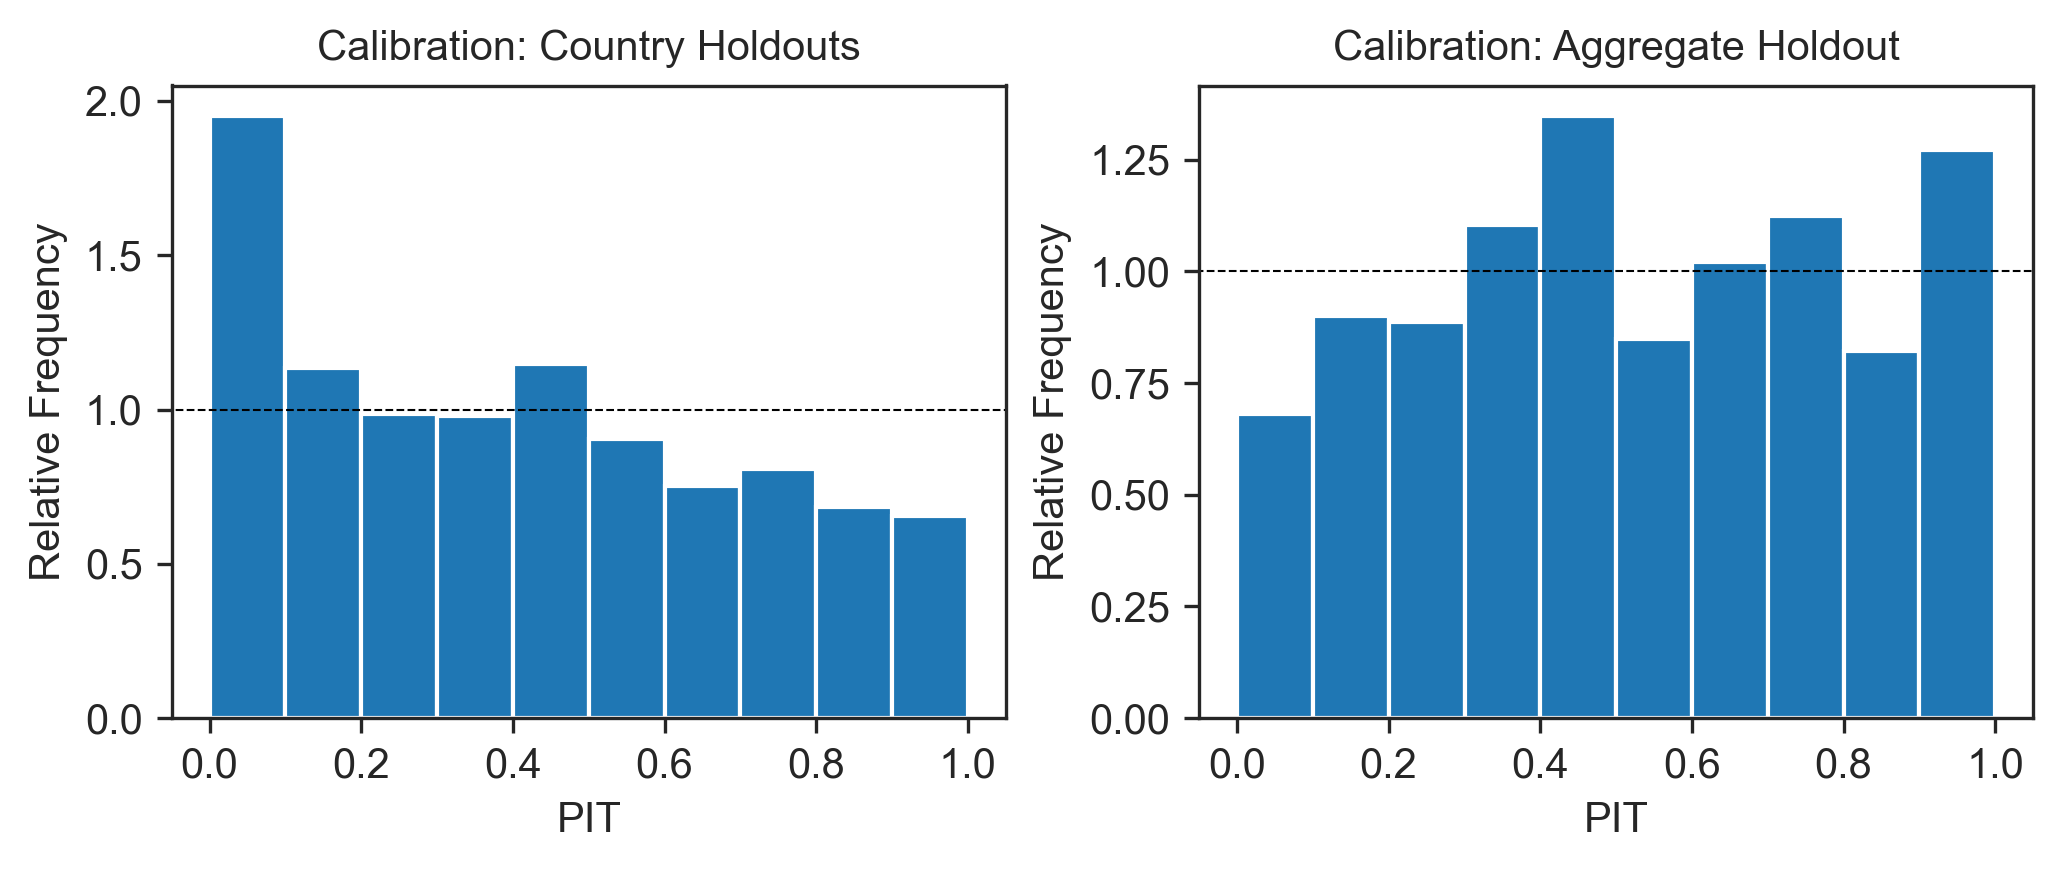

In [132]:
plt.figure(figsize=(7, 3), dpi=300)
plt.subplot(121)
all_cdf_vals = np.array(cdf_vals_cases)
all_cdf_vals = np.append(all_cdf_vals, cdf_vals_deaths)
plt.hist(all_cdf_vals, bins=10, density=True)
plt.title('Calibration: Country Holdouts', fontsize=10)
plt.xlabel('PIT', fontsize=10)
plt.ylabel('Relative Frequency')
plt.xlim(plt.xlim())
plt.plot([-1, 2], [1, 1], 'k--', linewidth=0.5)

plt.subplot(122)
all_cdf_vals_agg = np.array(cdf_vals_cases_agg)
all_cdf_vals_agg = np.append(all_cdf_vals_agg, cdf_vals_deaths_agg)
plt.hist(all_cdf_vals_agg, bins=10, density=True)
plt.title('Calibration: Aggregate Holdout', fontsize=10)
plt.xlabel('PIT', fontsize=10)
plt.ylabel('Relative Frequency')
plt.xlim(plt.xlim())
plt.plot([-1, 2], [1, 1], 'k--', linewidth=0.5)

plt.tight_layout()
plt.savefig('PIT_all_10.pdf', bbox_inches='tight')

In [156]:
plt.figure(figsize=(7, 3), dpi=300)
plt.subplot(121)
all_cdf_vals = np.array(cdf_vals_cases)
all_cdf_vals = np.append(all_cdf_vals, cdf_vals_deaths)
all_cdf_vals_trans = 2*np.abs(all_cdf_vals - 0.5)

x_vals = np.linspace(0, 1, 100)
counts = [np.mean(all_cdf_vals_trans < x) for x in x_vals]
plt.plot(x_vals, counts)
plt.title('Calibration: Country Holdouts', fontsize=10)
plt.xlabel('Confidence Interval', fontsize=10)
plt.ylabel('Empirical Cumulative Frequency')
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.5)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])

plt.subplot(122)
all_cdf_vals_agg = np.array(cdf_vals_cases_agg)
all_cdf_vals_agg = np.append(all_cdf_vals_agg, cdf_vals_deaths_agg)
all_cdf_vals_agg_trans = 2*np.abs(all_cdf_vals_agg - 0.5)
x_vals = np.linspace(0, 1, 100)
counts = [np.mean(all_cdf_vals_agg_trans < x) for x in x_vals]

plt.plot(x_vals, counts)
plt.title('Calibration: Aggregate Holdout', fontsize=10)
plt.xlabel('Confidence Interval', fontsize=10)
plt.ylabel('Empirical Cumulative Frequency')
plt.xlim(plt.xlim())
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.5)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])

plt.tight_layout()
plt.savefig('calcurve.pdf', bbox_inches='tight')

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

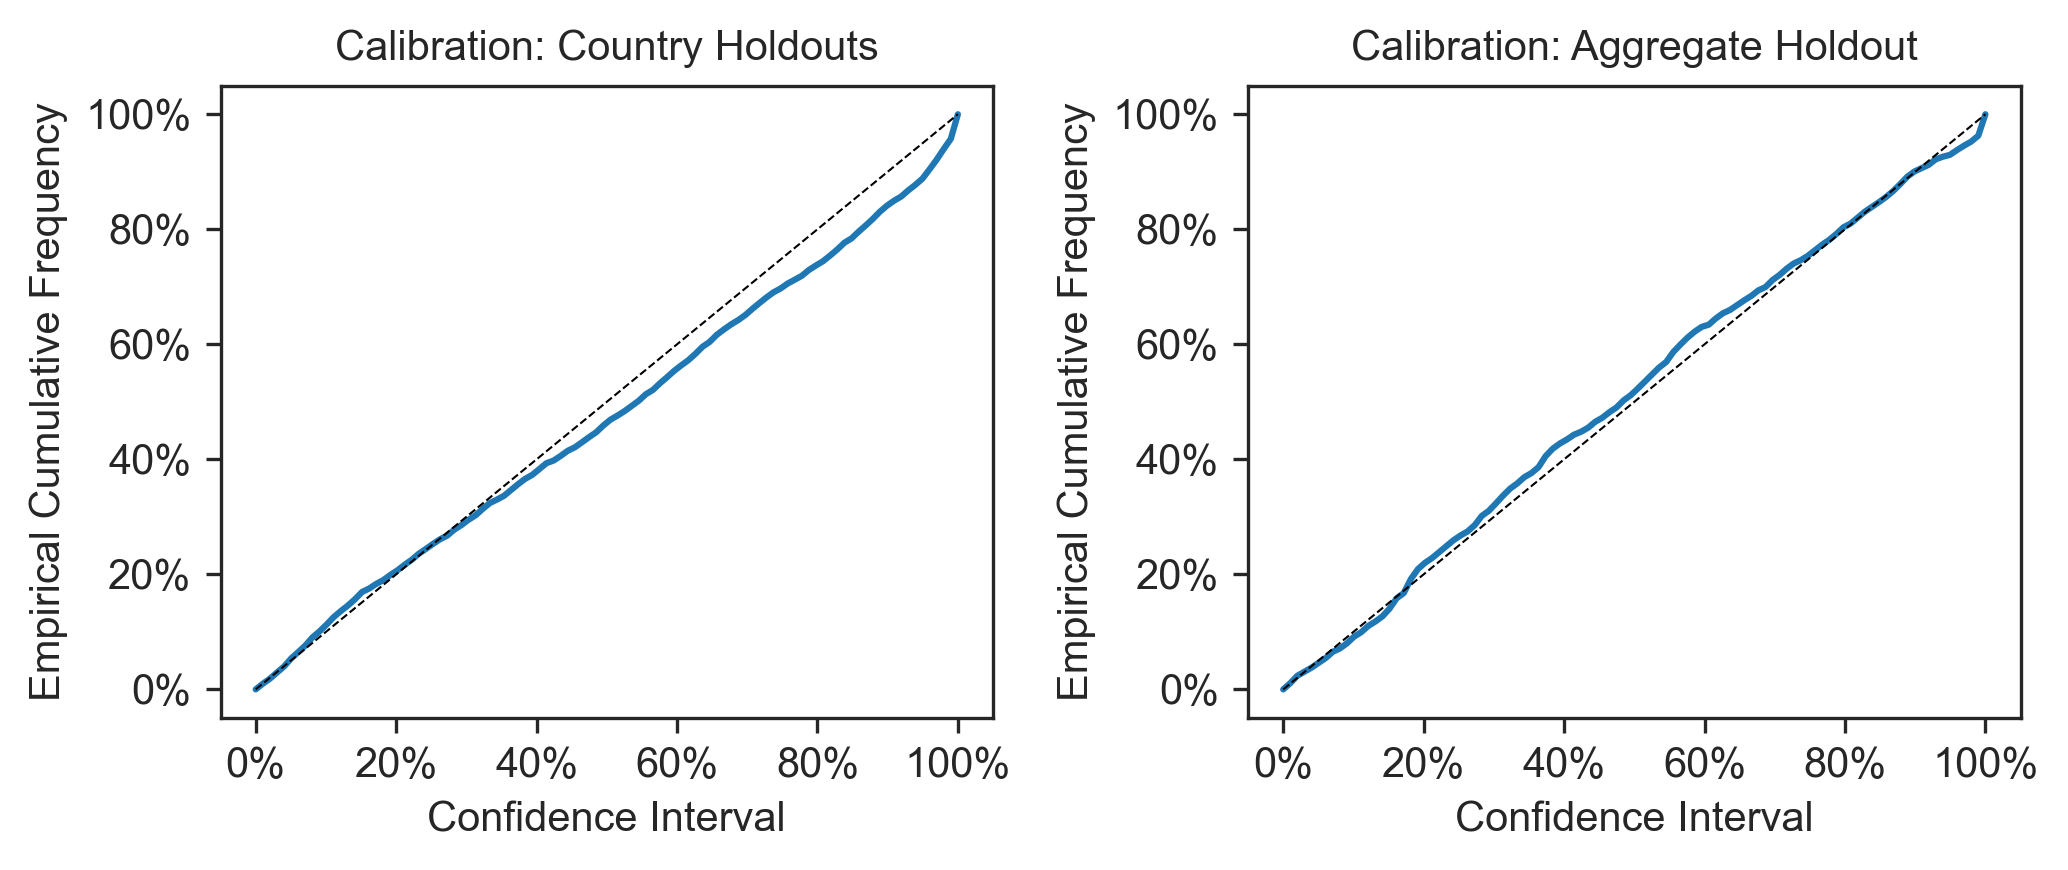

In [157]:
x_vals

In [146]:
counts

[0.0]

NameError: name 'h' is not defined

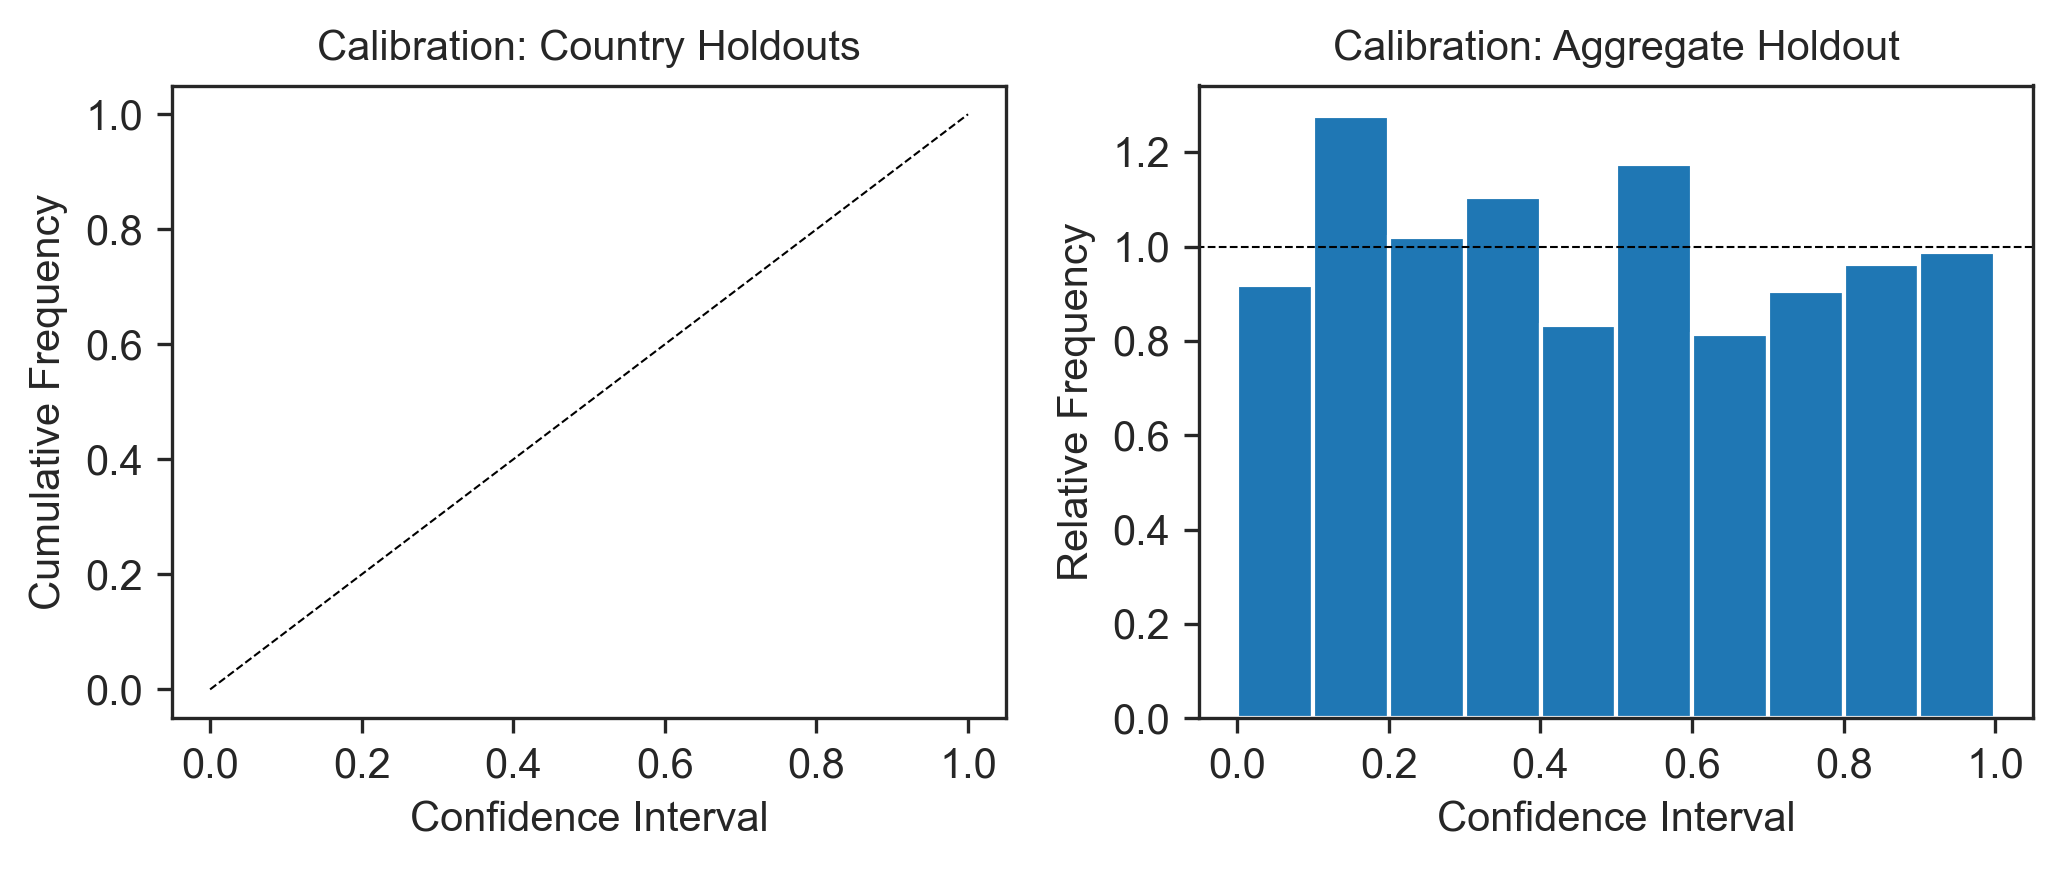

In [145]:
h